# TP1 - Grupo 4 - VAR

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt
import scipy.stats
import pylab
import statsmodels.tsa.stattools as tsa
import pmdarima as pm
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima, ndiffs, nsdiffs
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

##########################################################################################
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.io as pio
from datetime import datetime
from statsmodels.tsa.arima_model import ARMA
from pmdarima.arima import ADFTest
from statsmodels.tsa.api import VAR
##########################################################################################

from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20,10)})

# Series
## a) Pasajeros

In [3]:
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Pasajeros_TP.csv'
pasajeros_d = pd.read_csv(url)
pasajeros_d.rename({'FechaRecaudacion': 'fecha', 'Cantidad_Pasajeros': 'pas'}, axis=1, inplace=True)
pasajeros_d = pasajeros_d[(pasajeros_d['fecha'] >= '2021-10-01') & (pasajeros_d['fecha'] <= '2023-10-30')]
# Para la fecha jueves 13 de octubre del 2022, se observa el valor de 1 y para corregir este dato se optó por sacar el promedio de los dos dias posteriores y el valor del día anterior.
# Además se agregan las observaciones que corresponden a los días 2022-05-17, 2022-10-12, 2023-06-13 y 2023-06-22 con el valor de 1, posteriormente se reemplaza este valor por el promedio de los dos dias posteriores y el valor del día anterior.
# Agregar fechas faltantes
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'pas': 1},
                                     {'fecha': '2022-10-12', 'pas': 1},
                                     {'fecha': '2023-06-13', 'pas': 1},
                                     {'fecha': '2023-06-22', 'pas': 1}])
pasajeros_d = pd.concat([pasajeros_d, nuevas_observaciones], ignore_index=True)
# Ordenar el DataFrame por la columna de fechas
pasajeros_d = pasajeros_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
pasajeros_d = pasajeros_d.reset_index(drop=True)

# Convertir la columna 'Fecha' a tipo datetime
pasajeros_d['fecha'] = pd.to_datetime(pasajeros_d['fecha'], dayfirst=True, format="%Y-%m-%d")
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_17 = round(average_value_17, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_17
# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_12 = round(average_value_12, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_12
# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_13 = round(average_value_13, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_13
# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_6 = round(average_value_6, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_6
# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = pasajeros_d.index[pasajeros_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (pasajeros_d.loc[index_to_replace - 7, 'pas'] + pasajeros_d.loc[index_to_replace + 7, 'pas']) / 2

# Redondear el promedio con 0 decimales
average_value_22 = round(average_value_22, 0)

# Reemplazar el valor en el DataFrame
pasajeros_d.loc[index_to_replace, 'pas'] = average_value_22
# Formato diario
pasajeros_d.set_index('fecha', inplace=True)

pasajeros_d = pasajeros_d.asfreq('d')
pasajeros_d = pasajeros_d['pas']
pasajeros_d.describe()

count       760.000000
mean     175952.678947
std       82497.043937
min        5582.000000
25%      106144.500000
50%      178343.000000
75%      249701.000000
max      319953.000000
Name: pas, dtype: float64

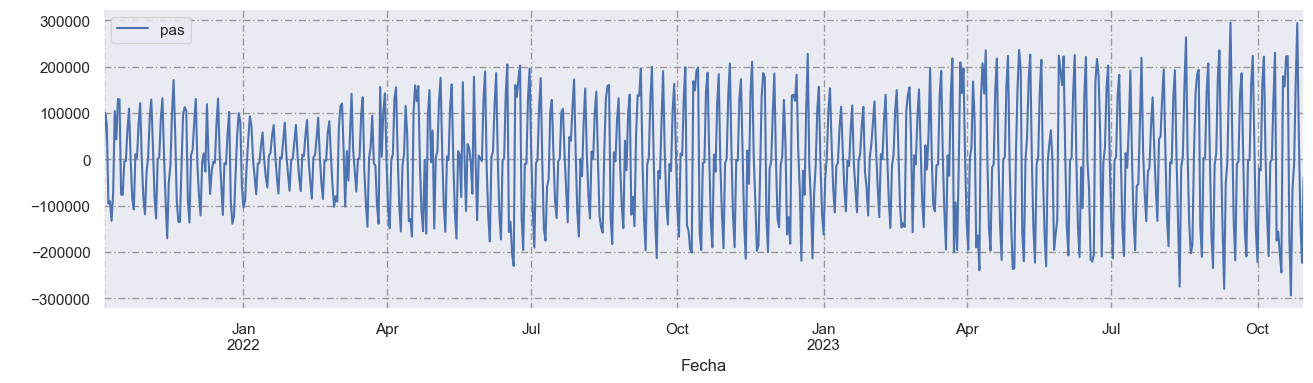

In [4]:
# Funcion para graficar

def graficar(serie, titulo="", xlabel="Fecha", ylabel=" "):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])
    serie.plot()
    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))
    
# Para remover la estacionalidad semanal,
# Hacemos una diferencia semanal y en el grafico ya no observamos un patron repetitivo

# Diferenciar la serie
pas_diff_4=pasajeros_d.copy()
pas_diff_4=pas_diff_4.diff(periods = 4)
pas_diff_4 = pas_diff_4.dropna()
graficar(pas_diff_4)

## b) Consumo

In [5]:
# Consumo
url = 'https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Consumo_TP.csv'
raw_csv_data = pd.read_csv(url, sep=',', decimal='.')
consumo_d = raw_csv_data.copy()
consumo_d = consumo_d[(consumo_d['Fecha'] >= '2021-10-01') & (consumo_d['Fecha'] <= '2023-10-30')]
consumo_d = consumo_d.loc[consumo_d.Consumo>0]
consumo_d.rename({'Fecha': 'fecha', 'Consumo': 'con'}, axis=1, inplace=True)
nuevas_observaciones = pd.DataFrame([{'fecha': '2022-05-17', 'con': 1},
                                     {'fecha': '2022-10-12', 'con': 1},
                                     {'fecha': '2022-10-13', 'con': 1},
                                     {'fecha': '2023-06-13', 'con': 1},
                                     {'fecha': '2023-06-22', 'con': 1}])
consumo_d = pd.concat([consumo_d, nuevas_observaciones], ignore_index=True)

# Ordenar el DataFrame por la columna de fechas
consumo_d = consumo_d.sort_values(by='fecha', ascending=True)

# Resetear el índice
consumo_d = consumo_d.reset_index(drop=True)

# Convertir la columna 'Fecha' a tipo datetime
consumo_d['fecha'] = pd.to_datetime(consumo_d['fecha'], dayfirst=True, format="%Y-%m-%d")
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_17

# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_12

# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_13

# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_6

# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = consumo_d.index[consumo_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (consumo_d.loc[index_to_replace - 7, 'con'] + consumo_d.loc[index_to_replace + 7, 'con']) / 2

# Reemplazar el valor en el DataFrame
consumo_d.loc[index_to_replace, 'con'] = average_value_22

# Formato diario
consumo_d.set_index('fecha', inplace=True)

consumo_d = consumo_d.asfreq('d')
consumo_d = consumo_d['con']
consumo_d.describe()

count    760.000000
mean      46.018249
std        3.446071
min       21.671538
25%       44.059896
50%       46.227106
75%       48.002559
max       55.802864
Name: con, dtype: float64

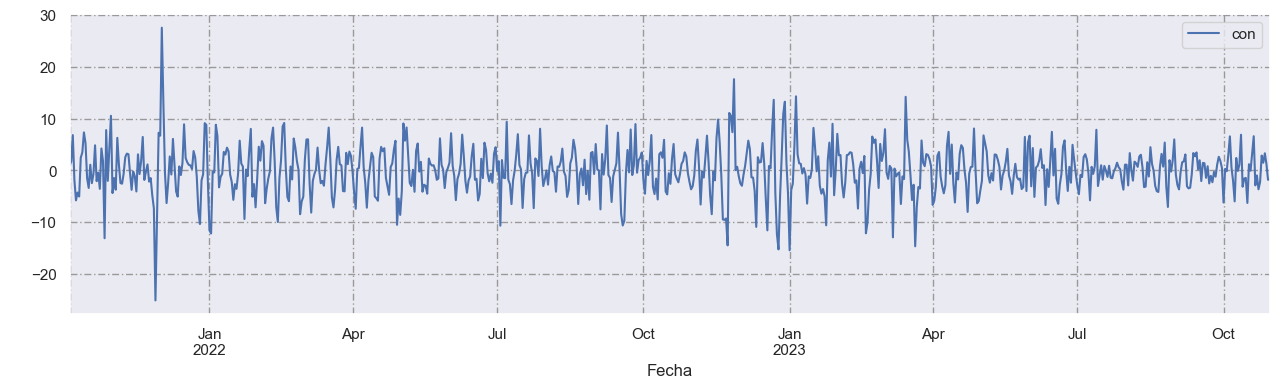

In [6]:
# Diferenciar la serie
con_diff_4=consumo_d.copy()
con_diff_4=con_diff_4.diff(periods = 4)
con_diff_4 = con_diff_4.dropna()
graficar(con_diff_4)

## c) Kilómetros

In [7]:
# KM
url='https://raw.githubusercontent.com/jiang-011/AST_G4/main/dataset/Kilometros_TP.csv'
raw_csv_data = pd.read_csv(url, sep=',', decimal='.')
km_d = raw_csv_data.copy()
km_d = km_d[(km_d['Fecha'] >= '2021-10-01') & (km_d['Fecha'] <= '2023-10-30')]

km_d.rename({'Fecha': 'fecha', 'KM': 'km'}, axis=1, inplace=True)
nuevas_observaciones = pd.DataFrame([{'fecha': '2023-06-22', 'km': 1}])
km_d = pd.concat([km_d, nuevas_observaciones], ignore_index=True)
km_d = km_d.sort_values(by=['fecha'], ascending=True)
km_d = km_d.reset_index(drop=True)
# Convertir la columna 'Fecha' a tipo datetime
km_d['fecha'] = pd.to_datetime(km_d['fecha'], dayfirst=True, format="%Y-%m-%d")
# Encontrar el índice correspondiente a '2022-05-17'
index_to_replace = km_d.index[km_d['fecha'] == '2022-05-17'][0]

# Calcular el promedio de una semana previa y una semana posterior
average_value_17 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_17

# Encontrar el índice correspondiente a '2022-10-12'
index_to_replace = km_d.index[km_d['fecha'] == '2022-10-12'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_12 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_12

# Encontrar el índice correspondiente a '2022-10-13'
index_to_replace = km_d.index[km_d['fecha'] == '2022-10-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_13 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_13

# Encontrar el índice correspondiente a '2023-06-13'
index_to_replace = km_d.index[km_d['fecha'] == '2023-06-13'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_6 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_6

# Encontrar el índice correspondiente a '2023-06-22'
index_to_replace = km_d.index[km_d['fecha'] == '2023-06-22'][0]

# Calcular el promedio de un día previo y un día posterior
average_value_22 = (km_d.loc[index_to_replace - 7, 'km'] + km_d.loc[index_to_replace + 7, 'km']) / 2

# Reemplazar el valor en el DataFrame
km_d.loc[index_to_replace, 'km'] = average_value_22

# Formato diario
km_d.set_index('fecha', inplace=True)

km_d = km_d.asfreq('d')
km_d = km_d['km']
km_d.describe()

count       760.000000
mean      73977.713023
std       23424.039351
min       17554.422000
25%       52696.933750
50%       75397.900000
75%       97051.868000
max      105834.661000
Name: km, dtype: float64

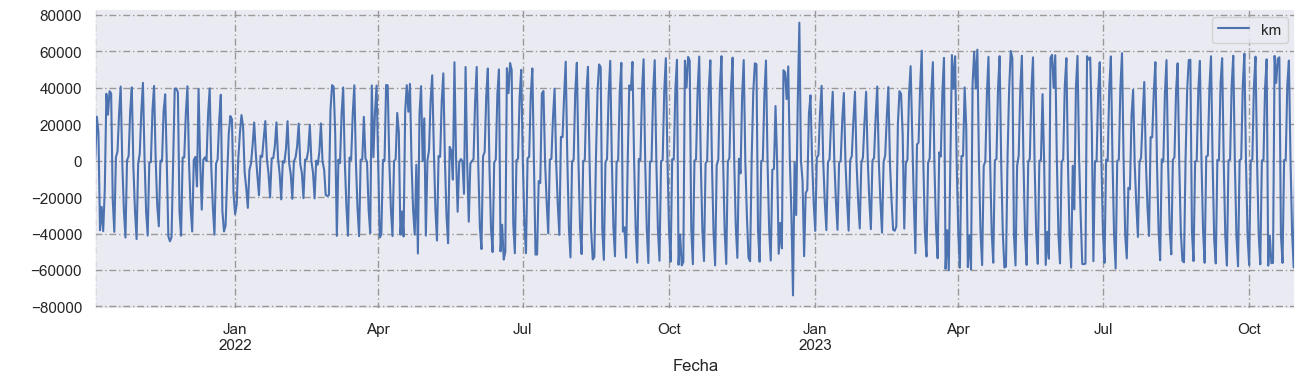

In [8]:
# Diferenciar la serie
km_diff_4=km_d.copy()
km_diff_4=km_diff_4.diff(periods = 4)
km_diff_4 = km_diff_4.dropna()
graficar(km_diff_4)

# Pregunta 10

Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.

In [9]:
# Dataframe de las tres series que se utilizarán para el modelo VAR
serieVAR=pd.concat([pas_diff_4, km_diff_4, con_diff_4], axis=1)

In [10]:
# Separacion Train/Test
# Seleccion de train
train = serieVAR[:-14]

# Seleccionamos de test
test = serieVAR[-14:]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train,"\n\n", test)

                 pas         km       con
fecha                                    
2021-10-05    6540.0    545.445  0.945639
2021-10-06  100021.0  24165.307  1.709404
2021-10-07   75013.0  15437.506  6.814571
2021-10-08  -95899.0 -38171.089 -1.813478
2021-10-09  -90643.0 -25337.853 -5.776567
...              ...        ...       ...
2023-10-12  230014.0  55632.198  6.877994
2023-10-13 -175508.0 -57590.980 -3.142773
2023-10-14 -156565.0 -41135.133 -1.573782
2023-10-15 -202617.0 -56291.287 -1.450329
2023-10-16 -244535.0 -56103.795 -6.272123

[742 rows x 3 columns] 

                  pas         km       con
fecha                                    
2023-10-17  179071.0  57498.272  1.194718
2023-10-18  156776.0  42680.509 -0.060832
2023-10-19  222331.0  55979.390  3.261288
2023-10-20  222533.0  56728.877  6.593475
2023-10-21 -163355.0 -41006.376 -2.883154
2023-10-22 -294116.0 -56116.457 -0.973448
2023-10-23  -64599.0    367.246 -3.639392
2023-10-24  -11471.0    337.499 -2.235867
2023-10

In [11]:
model = VAR(train)
x = model.select_order(maxlags=70)
x.summary()

,AIC,BIC,FPE,HQIC
0,43.31,43.33,6.441e+18,43.32
1,42.83,42.91,3.993e+18,42.86
2,42.60,42.74,3.175e+18,42.66
3,42.24,42.44,2.217e+18,42.32
4,41.51,41.77,1.066e+18,41.61
5,41.46,41.78,1.010e+18,41.58
6,41.47,41.85,1.022e+18,41.62
7,41.23,41.68,8.092e+17,41.41
8,40.97,41.47,6.200e+17,41.16
9,40.94,41.50,6.034e+17,41.16


In [12]:
model_fitted = model.fit(25)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Nov, 2023
Time:                     23:51:51
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    41.8107
Nobs:                     717.000    HQIC:                   40.9176
Log likelihood:          -17291.7    FPE:                3.36783e+17
AIC:                      40.3558    Det(Omega_mle):     2.48936e+17
--------------------------------------------------------------------
Results for equation pas
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const        1585.090166      1647.639201            0.962           0.336
L1.pas          0.381722         0.114970            3.320           0.001
L1.km          -0.493792         0.399424           -1.236           0.216
L1.con     

Predicción

In [13]:
# Funcion que recibe listas con las predicciones e intervalos de confianza de las 3 series y devuelve un
# dataframe para la serie indicada por la variable indice
def serializar(predicciones_, test_, indice, futuro_, intervalos=True):

    serie = {
        "FECHA": test_.index[:futuro_],
        "serie"+str(indice): predicciones_[0][:,indice-1].tolist(),
        "serie"+str(indice)+"_inf": predicciones_[1][:,indice-1].tolist(),
        "serie"+str(indice)+"_sup": predicciones_[2][:,indice-1].tolist()}
    serie = pd.DataFrame(serie, columns=["FECHA", "serie"+str(indice),
                                         "serie"+str(indice)+"_inf", "serie"+str(indice)+"_sup"])
    serie.set_index("FECHA", inplace=True)
    if (intervalos==False):
        serie.loc[serie["serie"+str(indice)+"_inf"] < 0, "serie"+str(indice)+"_inf"] = 0
        serie.loc[serie["serie"+str(indice)+"_sup"] < 0, "serie"+str(indice)+"_sup"] = 0
    return serie

In [14]:
def graficar_pred(serie_test, serie_pred, titulo="Valores Originales vs Predicciones",
                  xlabel="Fecha", ylabel="Valor", intervalos=True):
    # serie_test:
    # serie_pred:

    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.iloc[:,0].plot(label="Predicciones")
    if (intervalos==True):
        serie_pred.iloc[:,2].plot(label="Intervalo de Confianza Superior")
        serie_pred.iloc[:,1].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.5', dashes=(5,2,1,2))

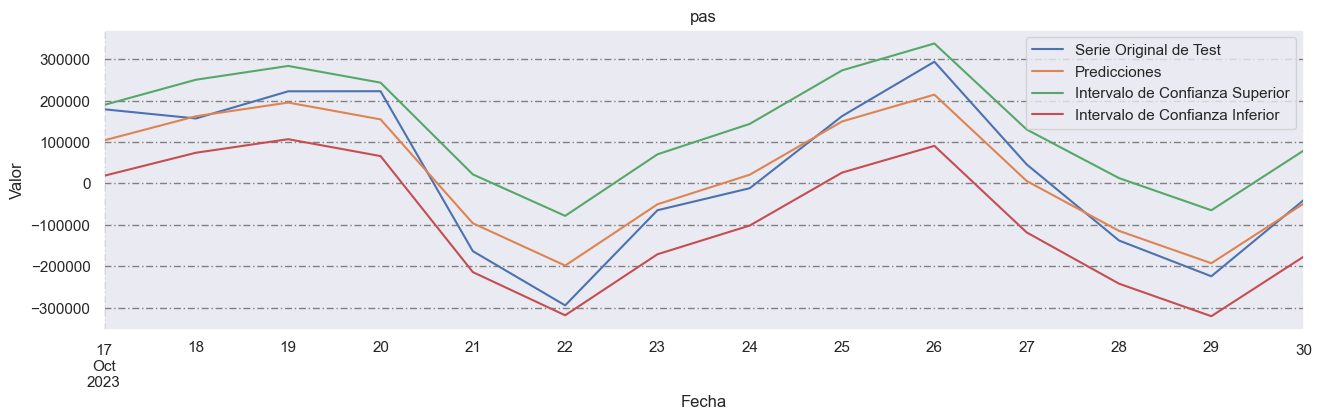

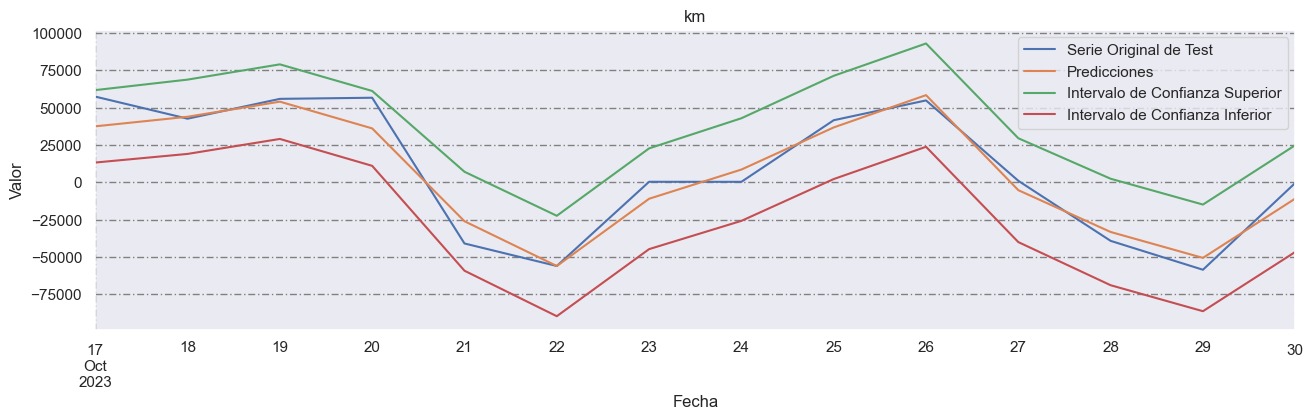

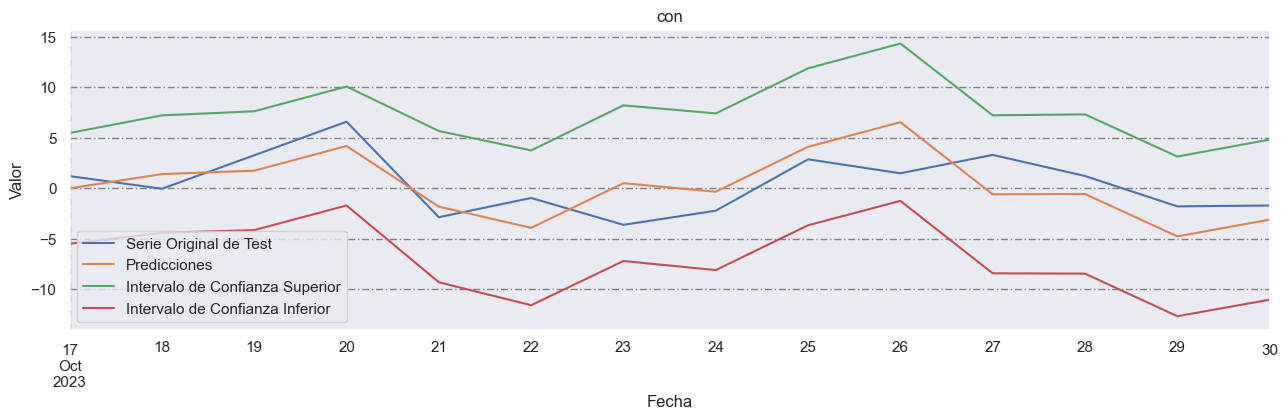

In [15]:
# Con la variable futuro se indican cuantas unidades en tiempo
# hacia adelante se quieren predecir
futuro = 14
lag_orden = 25

predicciones = model_fitted.forecast_interval(train.values[-lag_orden:], steps=futuro)

df = list()
for i in [1, 2, 3]:
    df.append(serializar(predicciones, test, i, futuro))

for i, serie in enumerate(serieVAR):
    graficar_pred(test[serie][:futuro], df[i], titulo=serie)

In [16]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [17]:
def test_residuos(residuos):


    # Test de Jarque Bera
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    jarquebera = jarque_bera(residuos)
    print('Jarque-Bera')
    print(f'p-valor: {jarquebera[1]}\n')

    # Test de Shapiro Wilks
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    shapir = shapiro(residuos)
    print('Shapiro')
    print(f'p-valor: {shapir[1]}\n')

In [18]:
def evaluar_residuos(residuos):
    residuos.plot(title='Residuos', figsize=(12, 3))
    plt.axhline(0, linestyle='--', color='k')
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    ax[0].set_title('Residuos KDE')
    ax[1].set_title('Q-Q Plot')
    residuos.plot(kind='kde', ax=ax[0])
    probplot(residuos, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(residuos)
    acf.set_size_inches(12,3)
    plt.show()
    print('Descriptivo Residuos\n')
    print(f'{residuos.describe()}\n\n')
    print('Test sobre los Residuos\n')
    test_residuos(residuos)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey

MSE: 19376751646.200806
MAE: 121884.92986561525
RMSE: 139200.40102744248
MAPE: 251782.9968
Evaluacion de residuos de Serie Pasajeros 


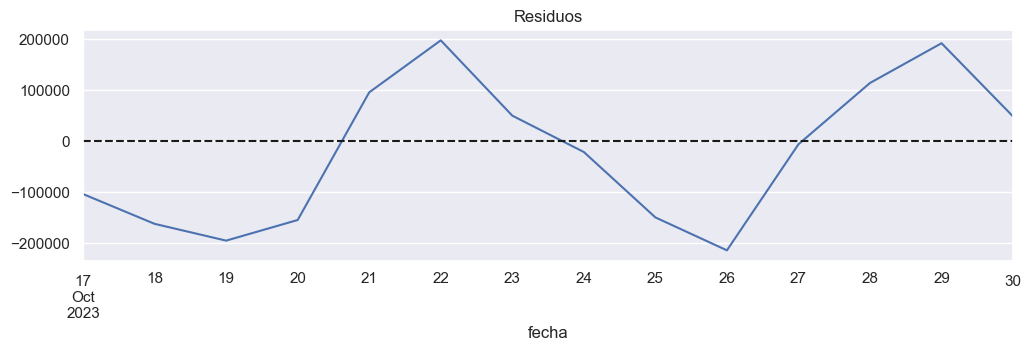

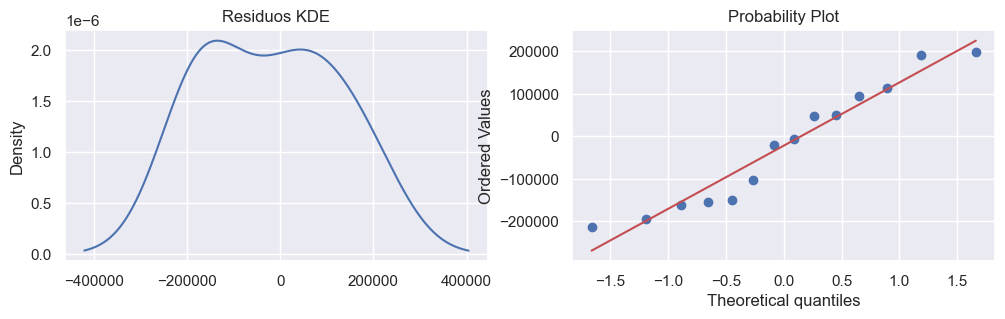

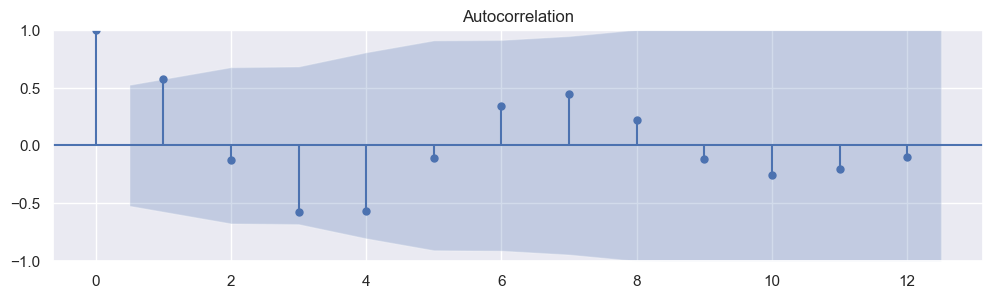

Descriptivo Residuos

count        14.000000
mean     -21892.019050
std      142657.436937
min     -214220.607278
25%     -153351.941009
50%      -13538.872610
75%       84592.225476
max      198132.541818
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.5795613140982114

Shapiro
p-valor: 0.25568687915802



In [20]:
evaluar_metricas(test[serie][:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie Pasajeros ")
evaluar_residuos(test[serie][:futuro]-df[0].iloc[:,0])

MSE: 1442868051.6707447
MAE: 33499.768057276924
RMSE: 37985.10302303713
MAPE: 68993.1071
Evaluacion de residuos de Serie Km 


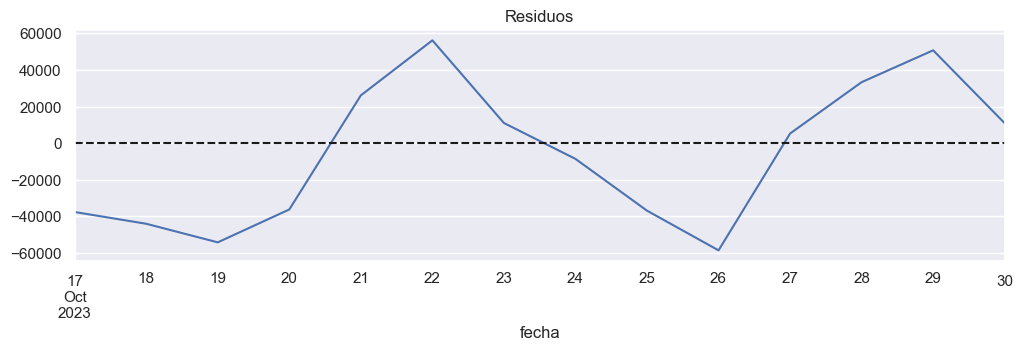

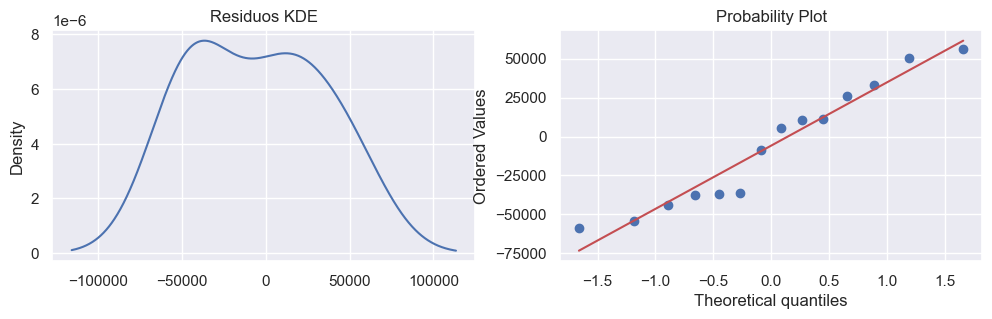

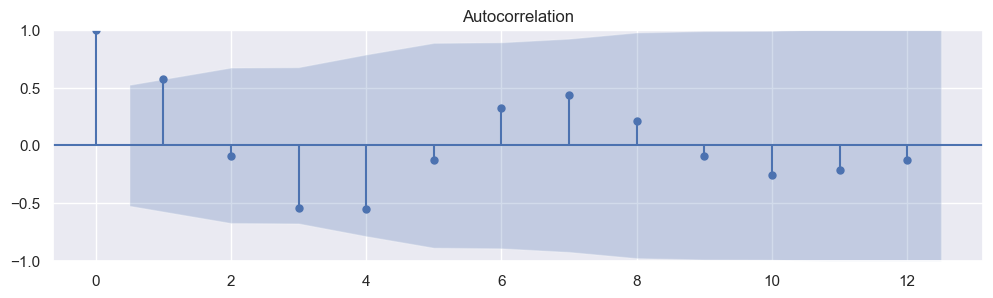

Descriptivo Residuos

count       14.000000
mean     -5876.480788
std      38944.428211
min     -58471.592179
25%     -37368.754318
50%      -1648.611287
75%      22324.059179
max      56116.888746
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.5808363099365593

Shapiro
p-valor: 0.2655819356441498



In [21]:
evaluar_metricas(test[serie][:futuro], df[1].iloc[:,0])
print(f"Evaluacion de residuos de Serie Km ")
evaluar_residuos(test[serie][:futuro]-df[1].iloc[:,0])

MSE: 7.057567152303848
MAE: 2.3590544208214874
RMSE: 2.6566082045163997
MAPE: 2.8689
Evaluacion de residuos de Serie Consumo 


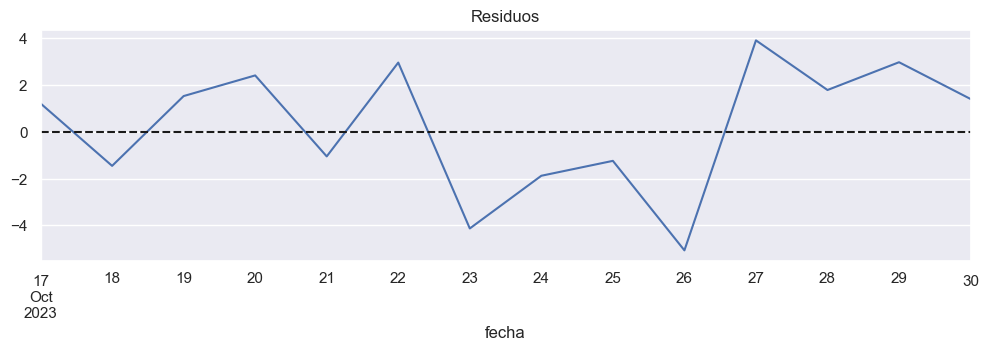

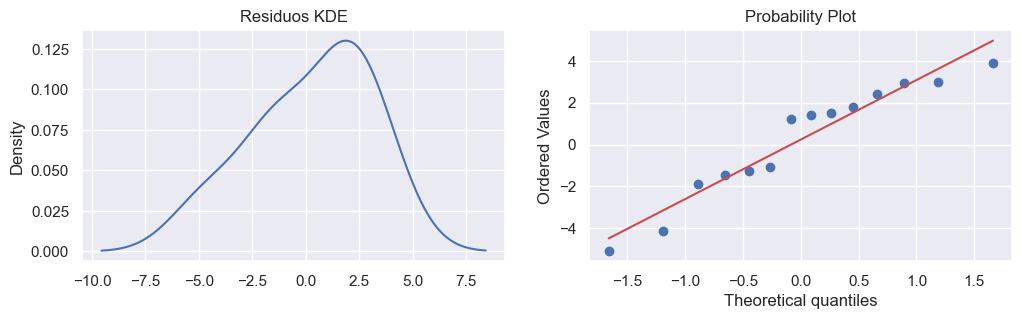

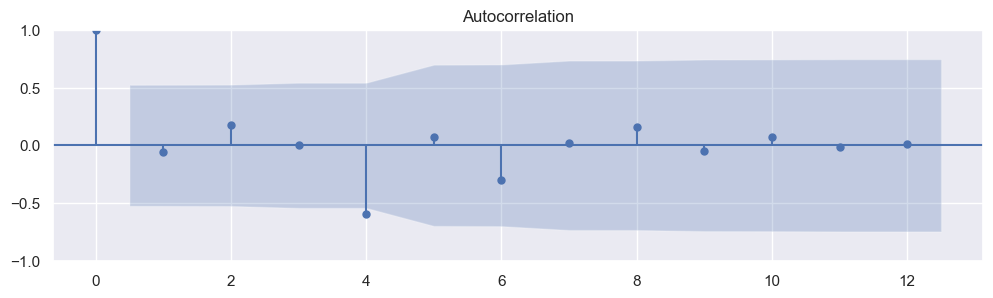

Descriptivo Residuos

count    14.000000
mean      0.240499
std       2.745572
min      -5.069158
25%      -1.402298
50%       1.308859
75%       2.256079
max       3.912024
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 0.5829163551361709

Shapiro
p-valor: 0.27593153715133667



In [22]:
evaluar_metricas(test[serie][:futuro], df[2].iloc[:,0])
print(f"Evaluacion de residuos de Serie Consumo ")
evaluar_residuos(test[serie][:futuro]-df[2].iloc[:,0])

Residuos Incorrelacionados y con comportamiento Normal (no hay evidencia estadística para el rechazo)


# Pregunta 11

Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad. Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis.

Cómo las variables en el modelo responden a un shock o perturbación en una de las variables

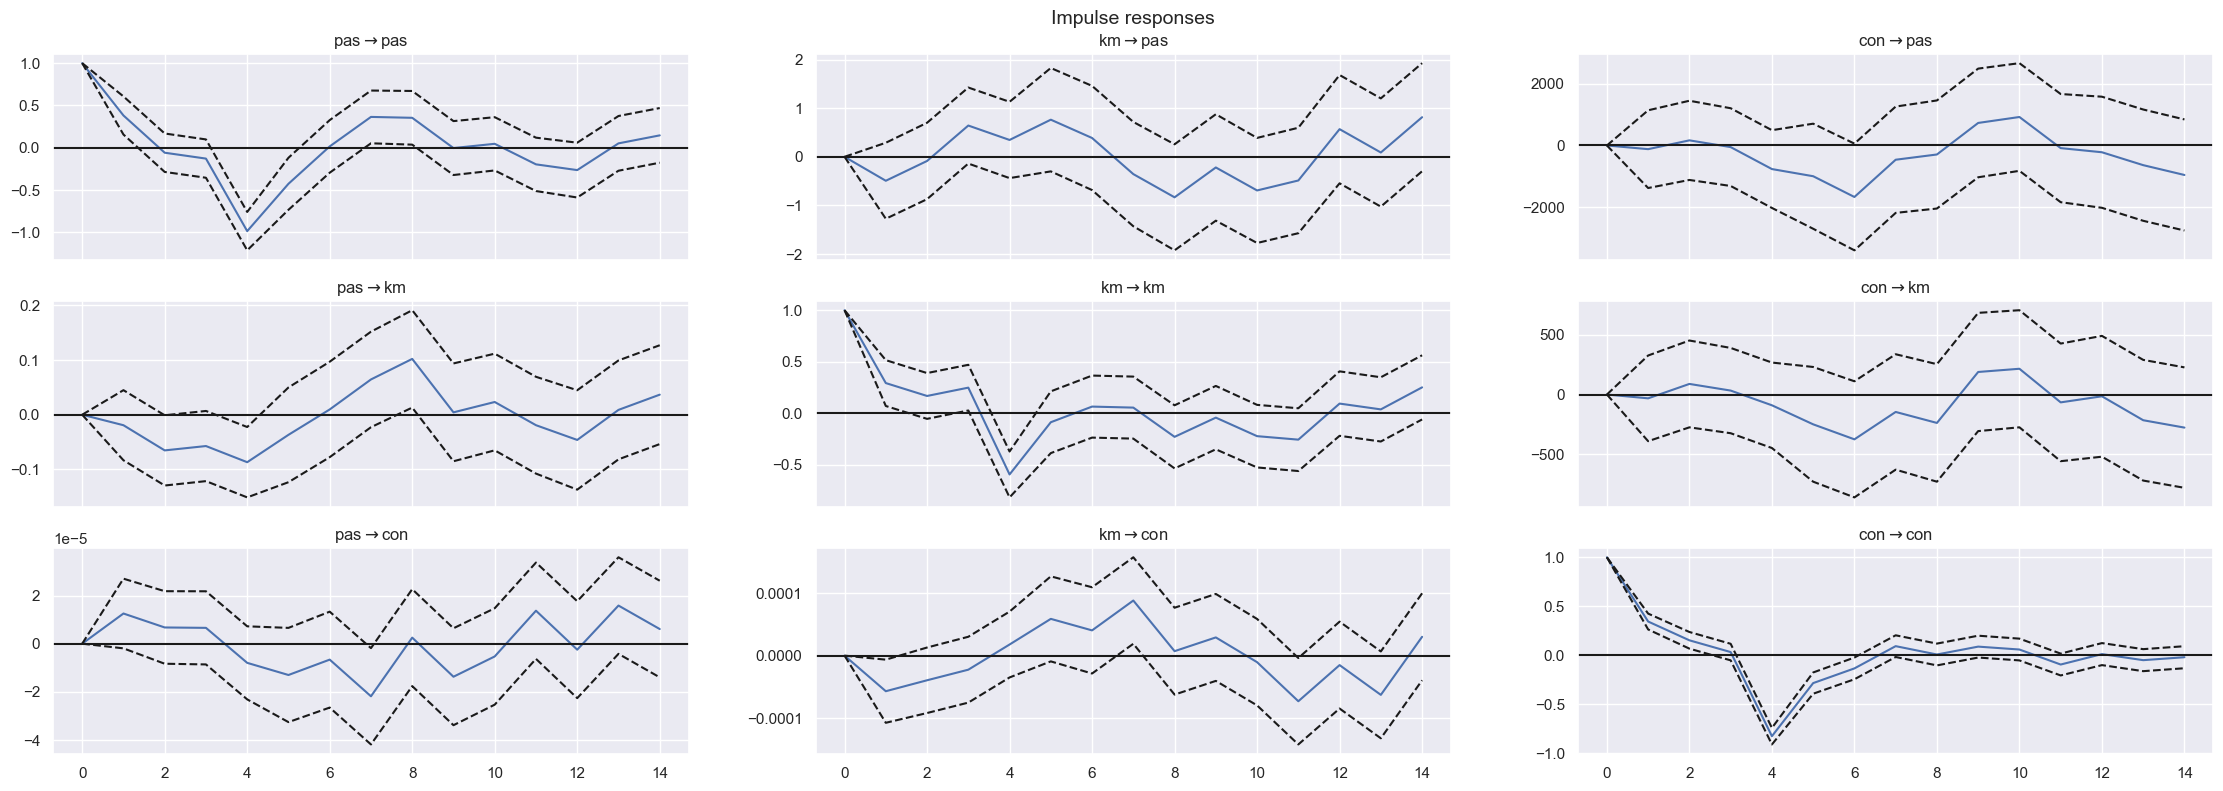

In [24]:
# Impulse response function for the model we trained
irf = model_fitted.irf(periods=14)
irf.plot(figsize=(24,8)) #Impulse response function plot
plt.show()

# Pregunta 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior. 

Opcional: Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.